#[GoingDeeper-4]Augmentation_cutmix_mixup_project

##1. 라이브러리 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

- GPU 환경 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2. 데이터 불러오기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
print("train data: ",len(ds_train))
print("test data: ",len(ds_test))

train data:  12000
test data:  8580


### 데이터 확인

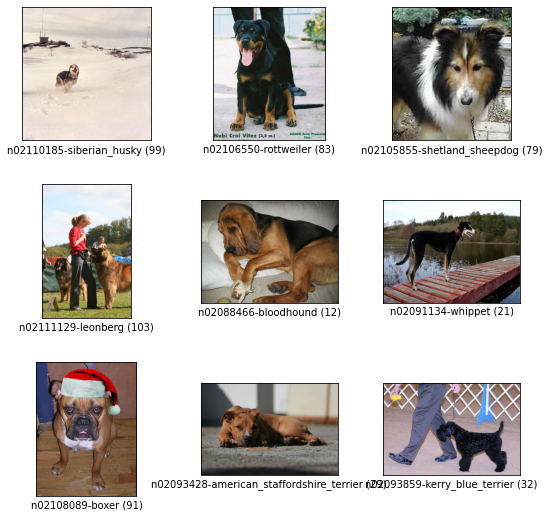

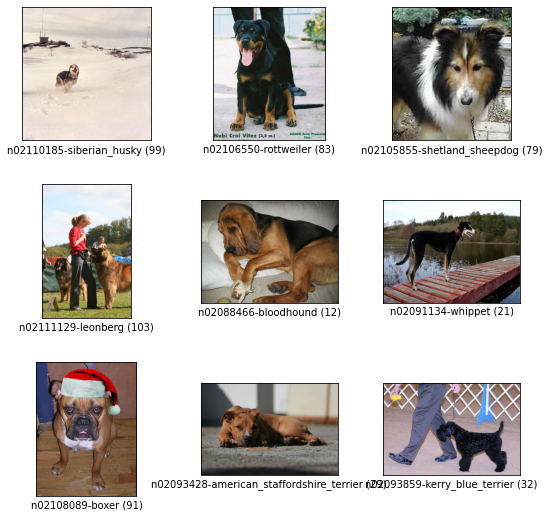

In [5]:
tfds.show_examples(ds_train, ds_info)

## 3. 데이터 전처리

- 데이터 전처리 함수

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label


##4. 모델 만들기(resnet50모델 사용)

In [7]:
#Augmentation 함수(flip, brightness적용)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

###4.1 Augmentaion을 적용하지 않은 모델

In [9]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

###4.2 Augmentaion을 적용한 모델

In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

###4.3 Cutmix를 적용한 모델

In [11]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

###4.4 Mixup를 적용한 모델

In [12]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

##5. 모델 훈련

In [13]:
EPOCH = 20

In [14]:
def onehot(image,label):
    CLASSES = num_classes
    return image,tf.one_hot(label,CLASSES)

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

###5.1 Augmentaion을 적용하지 않은 모델

In [16]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 97s 117ms/step - loss: 2.2102 - accuracy: 0.4463 - val_loss: 3.9654 - val_accuracy: 0.1237
Epoch 2/20
750/750 [==============================] - 87s 116ms/step - loss: 0.7273 - accuracy: 0.7990 - val_loss: 1.1042 - val_accuracy: 0.6769
Epoch 3/20
750/750 [==============================] - 87s 116ms/step - loss: 0.2531 - accuracy: 0.9447 - val_loss: 0.9906 - val_accuracy: 0.7137
Epoch 4/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0712 - accuracy: 0.9923 - val_loss: 0.9109 - val_accuracy: 0.7381
Epoch 5/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0229 - accuracy: 0.9990 - val_loss: 0.9063 - val_accuracy: 0.7432
Epoch 6/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0149 - accuracy: 0.9998 - val_loss: 0.9361 - val_accuracy: 0.7421
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0305 - accuracy: 0.9984 - val_loss: 0.9642 - val_accuracy: 0.7

###5.2 Augmentaion을 적용한 모델

In [17]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 93s 116ms/step - loss: 2.3037 - accuracy: 0.4259 - val_loss: 2.7935 - val_accuracy: 0.2931
Epoch 2/20
750/750 [==============================] - 86s 115ms/step - loss: 0.9254 - accuracy: 0.7337 - val_loss: 1.1710 - val_accuracy: 0.6603
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 0.4825 - accuracy: 0.8688 - val_loss: 1.1552 - val_accuracy: 0.6669
Epoch 4/20
750/750 [==============================] - 86s 115ms/step - loss: 0.2531 - accuracy: 0.9432 - val_loss: 1.0530 - val_accuracy: 0.6966
Epoch 5/20
750/750 [==============================] - 86s 115ms/step - loss: 0.1280 - accuracy: 0.9764 - val_loss: 1.0088 - val_accuracy: 0.7186
Epoch 6/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0708 - accuracy: 0.9910 - val_loss: 1.0615 - val_accuracy: 0.7139
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0437 - accuracy: 0.9952 - val_loss: 1.0590 - val_accuracy: 0.7

###5.3 CutMix와 MixUp 함수

- CutMix함수

In [18]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

In [19]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [20]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [21]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [22]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

- Mixup 함수

In [23]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [24]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [25]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True )
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=True)

###5.4 CutMix 모델

In [26]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 96s 118ms/step - loss: 3.8279 - accuracy: 0.2145 - val_loss: 3.6433 - val_accuracy: 0.1754
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 2.9549 - accuracy: 0.4325 - val_loss: 1.3196 - val_accuracy: 0.6245
Epoch 3/20
750/750 [==============================] - 88s 117ms/step - loss: 2.6201 - accuracy: 0.5367 - val_loss: 1.2647 - val_accuracy: 0.6434
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 2.4115 - accuracy: 0.6037 - val_loss: 1.2754 - val_accuracy: 0.6553
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 2.2629 - accuracy: 0.6491 - val_loss: 1.3917 - val_accuracy: 0.6215
Epoch 6/20
750/750 [==============================] - 88s 117ms/step - loss: 2.1362 - accuracy: 0.6982 - val_loss: 1.2328 - val_accuracy: 0.6691
Epoch 7/20
750/750 [==============================] - 88s 117ms/step - loss: 2.0478 - accuracy: 0.7188 - val_loss: 1.2506 - val_accuracy: 0.6

###5.5 MixUp 모델

In [27]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 97s 118ms/step - loss: 3.7150 - accuracy: 0.2485 - val_loss: 4.3143 - val_accuracy: 0.0940
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 2.8461 - accuracy: 0.4853 - val_loss: 1.3799 - val_accuracy: 0.6140
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 2.5544 - accuracy: 0.5928 - val_loss: 1.5425 - val_accuracy: 0.5880
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 2.3805 - accuracy: 0.6592 - val_loss: 1.2897 - val_accuracy: 0.6433
Epoch 5/20
750/750 [==============================] - 88s 118ms/step - loss: 2.2545 - accuracy: 0.7087 - val_loss: 1.2602 - val_accuracy: 0.6569
Epoch 6/20
750/750 [==============================] - 88s 118ms/step - loss: 2.1426 - accuracy: 0.7517 - val_loss: 1.2210 - val_accuracy: 0.6670
Epoch 7/20
750/750 [==============================] - 89s 118ms/step - loss: 2.0729 - accuracy: 0.7775 - val_loss: 1.4480 - val_accuracy: 0.6

##6. 모델 결과 시각화

###6.1 No Augmentation / With Augmentation

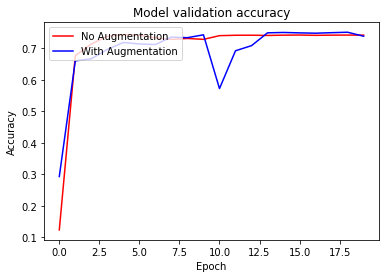

In [33]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

- Accuracy(0.72 ~ 0.76)

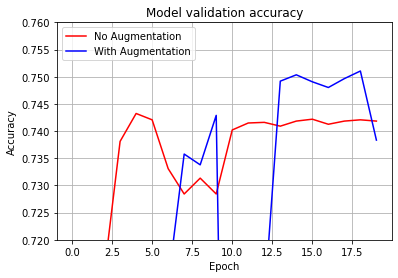

In [34]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

###6.2 No Augmentation / With Augmentation / CutMix

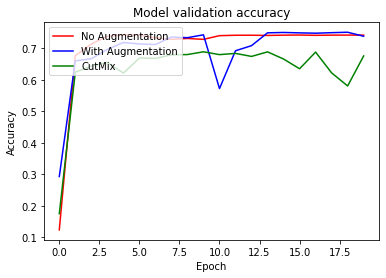

In [35]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','CutMix'], loc='upper left')
plt.show()

- Accuracy(0.72 ~ 0.76)

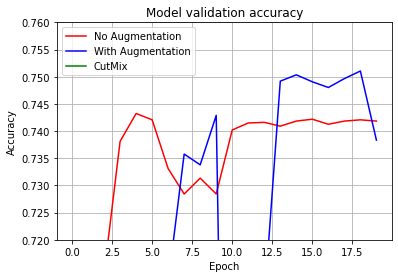

In [37]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','CutMix'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

###6.3 No Augmentation / With Augmentation / CutMix / MixUp

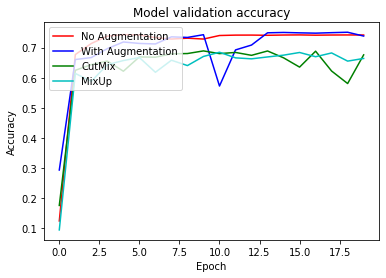

In [36]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'c')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','CutMix','MixUp'], loc='upper left')
plt.show()

- Accuracy(0.72 ~ 0.76)

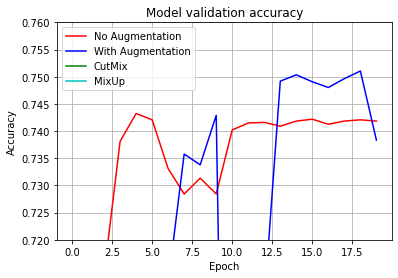

In [38]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'c')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','CutMix','MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

###6.4 CutMix / MixUp

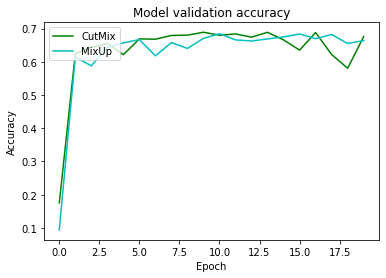

In [39]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'c')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CutMix','MixUp'], loc='upper left')
plt.show()

- Accuracy(0.6 ~ 0.7)

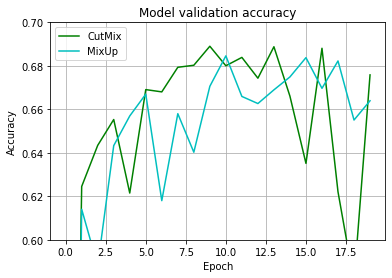

In [40]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'c')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CutMix','MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.6, 0.7)   
plt.show()

##7. 회고

- 4개 모델 모두 1EPOCH당 1분 30초가 걸렸고 20EPOCH이니 1개 모델당 30분으로 4개 모델을 학습하는데에만 2시간이나 걸렸다.
- 6.1을 보면 6EPOCH에서 Augmentation을 적용한 모델이 Accuracy가 높았다가 다시 떨어지고 다시 높아지는 현상을 볼 수 있었다.
- 20EPOCH후 다시 떨어지는 것으로 보아 EPOCH를 늘렸더라도 Accuracy가 높아질 것이라는 가능성은 희박할 수 있다.
- With Augmentation을 제외한 CutMix, Mixup모델은 Accuracy가 No Augmentation보다 낮은 것을 알 수 있었다.
- CutMix와 MixUp은 EPOCH를 늘린다면 No Augmentation보다 Accuracy가 높아질 것이라고 예상한다.